## daily data updates of science data

Authors: C. Möstl, E. E. Davies, E. Weiler, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'


Issues:

- only for Bepi: convert HEEQ to RTN - check difference after normalizing vectors


#### Orbits:

need to copy these updated kernel files manually to the kernel paths, and change filenames in code (!)
- SolO Kernels are available at:  https://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/spk/
then change filename in hd.solo_furnish
- STEREO-A kernels are available at: 


all: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/


for science data: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/ahead/

predicted: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/epm/ahead/

- PSP Kernels https://soho.nascom.nasa.gov/solarsoft/psp/gen/data/spice/orbit/
use file like "spp_nom_20180812_20300101_v042_PostV7.bsp" and change filename in psp furnish

- BepiColombo https://naif.jpl.nasa.gov/pub/naif/BEPICOLOMBO/kernels/spk/, use latest file and change filename in hd.bepi furnish

- generic kernels https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/

#### Data:

- STEREO-A science data: https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l2/impact/magplasma/1min/
- PSP check data availability at: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min
- Wind plasma: https://spdf.gsfc.nasa.gov/pub/data/wind/swe/ascii/swe_kp_unspike/ 
- Wind MAG: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/ascii/1min_ascii/

- OMNI: https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/ 




In [1]:
# https://github.com/cmoestl/heliocats  data_update_web_science.py

# for updating data every day on the servers

#switches
debug_mode=0
#always turn off debug mode when deploying!

get_omni=1
get_wind=1
get_psp=1
get_solo=1
get_bepi=1
get_stereoa=1

import numpy as np
import pandas as pd
import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import sys
import glob
import os   
import copy
import datetime
from datetime import datetime, timedelta
import scipy.signal
import urllib
import urllib.request
from urllib.request import urlopen
import json
import time
import h5py
import pytz
import cdflib
import spiceypy
import glob
import json
from bs4 import BeautifulSoup 
from astropy.time import Time, TimeDelta
import astrospice
import astropy.units as u
from astropy.constants import au

from sunpy.coordinates import HeliocentricInertial, HeliographicStonyhurst,HeliocentricEarthEcliptic


from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 



################################################ CHECK  ##############################################


#import warnings
#warnings.filterwarnings("ignore")


print('debug_mode is set to: ',debug_mode)


print('switches: OMNI',get_omni,' Wind',get_wind,'  PSP',get_psp,'  SolO',get_solo,' Bepi',get_bepi,' STEREO-A',get_stereoa )

####################################################################################################################

os.system('jupyter nbconvert --to script data_update_web_science.ipynb')   


#test execution times
t0all = time.time()

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


system is mac
debug_mode is set to:  1
switches: OMNI 0  Wind 0   PSP 0   SolO 0  Bepi 1  STEREO-A 0


[NbConvertApp] Converting notebook data_update_web_science.ipynb to script
[NbConvertApp] Writing 19723 bytes to data_update_web_science.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import solo_path    
    from config_server import psp_path 
    from config_server import bepi_path  
    from config_server import stereoa_path
    from config_server import kernels_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import solo_path 
    from config_local import bepi_path 
    from config_local import psp_path 
    from config_local import stereoa_path
    from config_local import kernels_path 
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(solo_path)
print(stereoa_path)
print(kernels_path)
#print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'solo') == False: os.mkdir(plot_path+'solo')
if os.path.isdir(plot_path+'psp') == False: os.mkdir(plot_path+'psp')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(solo_path) == False: os.mkdir(solo_path)
if os.path.isdir(solo_path) == False: os.mkdir(psp_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/solo/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/kernels/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### OMNI2

 
------ OMNI2 
OMNI data NOT downloaded and pickled, turn on switch
make OMNI plot
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_2024_Mar_26_2025_Mar_26.png
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_2024_Mar_26_2025_Mar_26.pdf
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_now.png
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_now.pdf


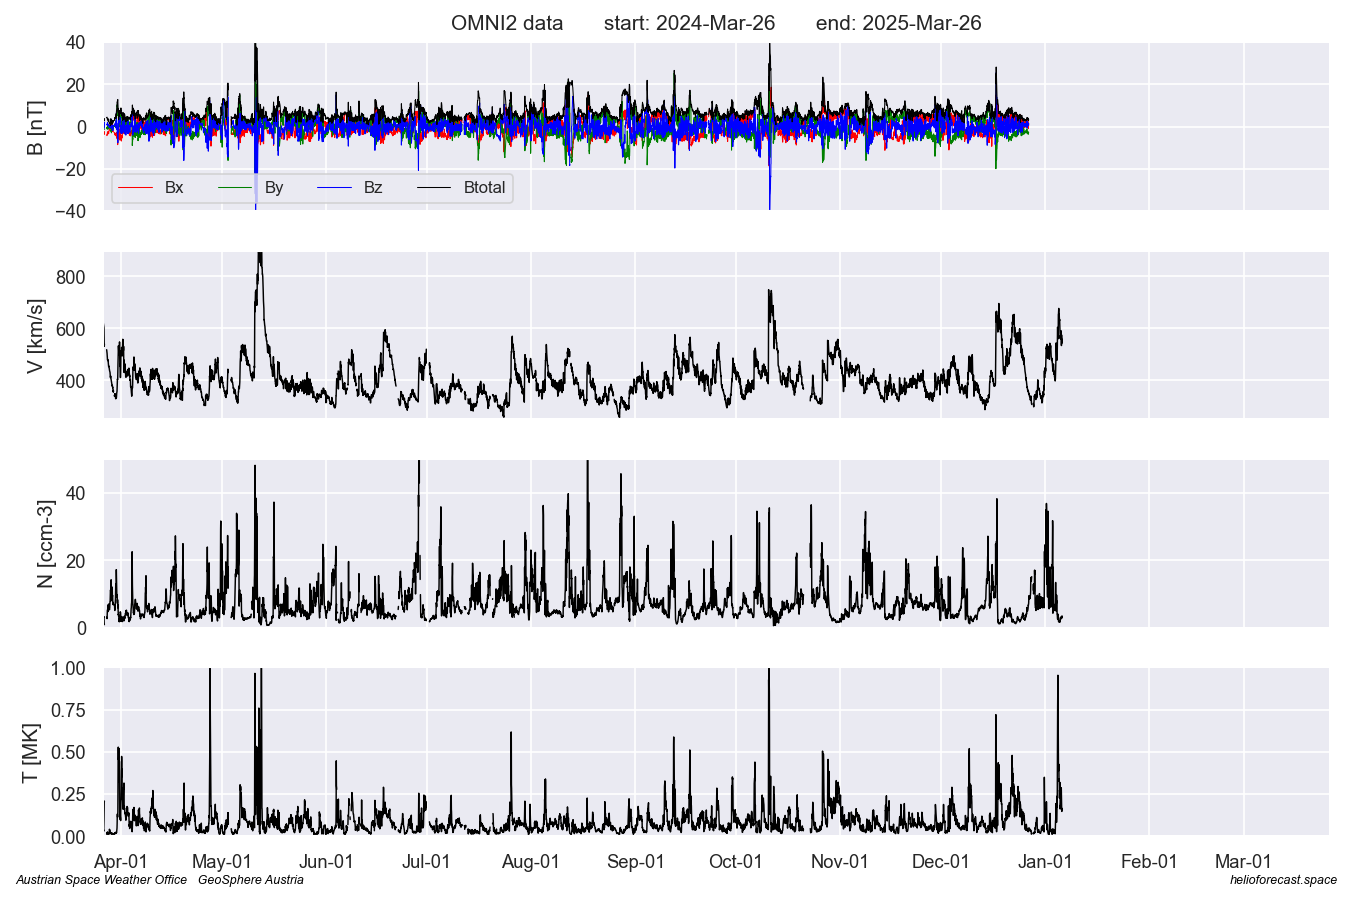

In [3]:

if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    
print(' ')
print('------ OMNI2 ')


# OMNI2
fileomni="omni_1963_now.p"
#this function downloads and saves the the omni2 data
if get_omni: 
    hd.save_omni_data(data_path,fileomni)
else:
    print('OMNI data NOT downloaded and pickled, turn on switch')
    
    
print('make OMNI plot')    
[o,ho]=pickle.load(open(data_path+fileomni, "rb" ) )  
start=datetime.utcnow() - timedelta(days=365)
end=datetime.utcnow() 
hp.plot_insitu_update(o, start, end,'OMNI2',plot_path+'omni2/',now=True)

### Wind 

In [4]:
print(' ')
#for server
start_time= datetime(1995,1,1)
#end_time  = datetime(2020,4,20)
end_time = datetime.utcnow() 
wind_file=data_path+'wind_1995_now_gse.p'
wind_file_heeq=data_path+'wind_1995_now_heeq.p'
wind_file_rtn=data_path+'wind_1995_now_rtn.p'


#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    
    #NOTE: for debugging start and end time needs to be in 2 separate years!! only for Wind
    start_time= datetime(2023,12,1)
    end_time  = datetime(2024,1,10)
    wind_file=data_path+'wind_gse_test.p'
    wind_file_heeq=data_path+'wind_heeq_test.p'
    wind_file_rtn=data_path+'wind_rtn_test.p'


# download data for current and previous year
if get_wind > 0:
 
    
    print('-------------------------------- Wind -------------------------- ')
    print('download Wind data ')

    t0 = time.time() 
    
    #get all years
    #hd.wind_download_ascii(1995, wind_path)     
    #when all is downloaded just start with the current or previous year to now
    hd.wind_download_ascii(2025, wind_path) 
    
    print('download Wind data done ')
    
    
    print('Process Wind to pickle')
    print(wind_path)
    print(wind_file)
    hd.save_wind_data_ascii(start_time,end_time,wind_path,wind_file,'GSE')
    
    #convert to HEEQ
    [data,header]=pickle.load(open(wind_file, "rb"))
    data_heeq=hd.convert_GSE_to_HEEQ(data)
    header_heeq=hd.wind_heeq_header(data_heeq)    
    pickle.dump([data_heeq,header_heeq], open(wind_file_heeq, "wb"))

    #convert to RTN
    data_rtn=hd.convert_HEEQ_to_RTN(data_heeq)
    header_rtn=hd.wind_rtn_header(data_rtn)    
    pickle.dump([data_rtn,header_rtn], open(wind_file_rtn, "wb"))
    
    t1=time.time()   

    
    print(' ')
    print('Wind done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
    
else:
    print('Wind data NOT downloaded or processed, turn on switch')  
 

 
Wind data NOT downloaded or processed, turn on switch


In [5]:
#data checks
if get_wind > 0:  

    filewind='wind_1995_now_gse.p'   
    filewind_heeq='wind_1995_now_heeq.p'   
    filewind_rtn='wind_1995_now_rtn.p'   
    
    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filewind='wind_gse_test.p'
        filewind_heeq='wind_heeq_test.p'
        filewind_rtn='wind_rtn_test.p'


    #for GSE file
    [data,hwin]=pickle.load(open(data_path+filewind, "rb"))
    print(hwin)
    print(' ')
    hp.data_overview_plot(data,plot_path+'wind/'+filewind[:-2])
    
    
    #same for HEEQ file            
    [data_heeq,hwin_heeq]=pickle.load(open(data_path+filewind_heeq, "rb"))
    print(hwin_heeq)
    print(' ')

    hp.data_overview_plot(data_heeq,plot_path+'wind/'+filewind_heeq[:-2])

    #same for RTN file            
    [data_rtn,hwin_rtn]=pickle.load(open(data_path+filewind_rtn, "rb"))
    print(hwin_rtn)
    hp.data_overview_plot(data_rtn,plot_path+'wind/'+filewind_rtn[:-2])

 

### Parker Solar Probe


In [6]:
print(' ')


####### -------- control parameter    
#server
start_time= datetime(2018,10,1)
#end_time= datetime(2018,10,10)
#start_time= datetime(2022,12,1)
end_time = datetime.utcnow() 
psp_file=data_path+'psp_2018_now_rtn.p'


if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    start_time= datetime(2024,4,1)
    end_time  = datetime(2024,9,1)
    psp_file=data_path+'psp_rtn_test.p'

    
if get_psp > 0:    

    t0 = time.time()  

    print('--------------------- PSP ------------------------- ')
    print('download PSP data until today ')
    print(psp_path)
    
    #for loading all data
    #hd.download_pspmag_1min(start_time,end_time,psp_path)
    #hd.download_pspplas(start_time,end_time,psp_path)

    
    #for debugging
    #hd.download_pspmag_1min(datetime(2024,1,1),datetime(2024,4,30),psp_path)
    #hd.download_pspplas(datetime(2024,11,1),datetime(2024,4,30),psp_path)

    
    #for loading data of the last few available months
    hd.download_pspmag_1min(datetime(2024,4,1),datetime(2024,10,14),psp_path)
    hd.download_pspplas(datetime(2024,4,1),datetime(2024,10,14),psp_path)

    print('process PSP to pickle')
    hd.create_psp_pkl(start_time,end_time,psp_file,psp_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('PSP done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
    
    
    
    
else:
    print('PSP data NOT downloaded and pickled, turn on switch')  


  

 
PSP data NOT downloaded and pickled, turn on switch


In [8]:
if get_psp > 0:   
    
    ### data checks
    filepsp='psp_2018_now_rtn.p'
    if debug_mode > 0: filepsp='psp_rtn_test.p'
    [data,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )

    ############ print header
    print(hpsp)

    ########## add overview plots
    hp.data_overview_plot(data,plot_path+'psp/'+filepsp[:-2])



### Solar Orbiter

In [9]:
print(' ')

####### -------- control parameter    

#for server
start_time= datetime(2020,4,14)
#end_time  = datetime(2020,4,20)
end_time = datetime.utcnow() 
solo_file=data_path+'solo_2020_now_rtn.p'

#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2024,7,1)
    end_time  = datetime(2024,8,1)
    solo_file=data_path+'solo_rtn_test.p'


if get_solo > 0:    

    t0 = time.time()  

    print('--------------------- SolO ------------------------- ')
    print('download SolO science data until today ')
    print(solo_path)

    #don't check all years for faster download
    hd.download_solomag_1min(datetime(2024,1,1),end_time,solo_path)
    hd.download_soloplas(datetime(2024,1,1),end_time,solo_path)

    print('process Solar Orbiter to pickle')
    hd.create_solo_pkl(start_time,end_time,solo_file,solo_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('Solo done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Solo data NOT downloaded and pickled, turn on switch')  


 
Solo data NOT downloaded and pickled, turn on switch


In [10]:
if get_solo > 0:  
    
    ### data checks

    filesolo='solo_2020_now_rtn.p'   

    if debug_mode > 0: filesolo='solo_rtn_test.p'

    [data,hsolo]=pickle.load(open(data_path+filesolo, "rb"))
    ############ print header
    print(hsolo)

    ########## add overview plots
    hp.data_overview_plot(data,plot_path+'solo/'+filesolo[:-2])


### BepiColombo

In [17]:
print(' ')

print(debug_mode)

####### -------- control parameter    
#server
start_time= datetime(2019,3,6)
end_time = datetime.utcnow()
bepi_file_ob=data_path+'bepi_ob_2019_now_e2k.p'
bepi_file_ob_rtn=data_path+'bepi_ob_2019_now_rtn.p'
bepi_file_ib=data_path+'bepi_ib_2019_now_e2k.p'
bepi_file_ib_rtn=data_path+'bepi_ib_2019_now_rtn.p'

if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    #testing
    start_time= datetime(2023,2,25)
    end_time= datetime(2023,2,28)
    #end_time  = datetime(2025,1,31)    
    bepi_file_ob=data_path+'bepi_ob_e2k_test.p'
    bepi_file_ob_rtn=data_path+'bepi_ob_rtn_test.p'
    bepi_file_ib=data_path+'bepi_ib_e2k_test.p'
    bepi_file_ib_rtn=data_path+'bepi_ib_rtn_test.p'

    
if get_bepi > 0:    

    t0 = time.time()  

    print('--------------------- Bepi ------------------------- ')
    print('!!! download Bepi data manually, or check ESA PSA ')
    print(bepi_path)
    print(bepi_file_ob)
    print(bepi_file_ib)

    
    print(' ')

    print('process Bepi to pickle')
    
    #outbound
    hd.create_bepi_pickle(start_time,end_time,bepi_file_ob,bepi_path, 'outbound',kernels_path)
    [data,hbepi_ob]=pickle.load(open(bepi_file_ob, "rb"))
    
    
    
    data_hee=hd.convert_E2K_to_HEE(data,kernels_path)
    data_heeq=hd.convert_HEE_to_HEEQ(data_hee)
    data_rtn=hd.convert_HEEQ_to_RTN_mag(data_heeq)       
    header_rtn=hd.bepi_rtn_header(data_rtn,'inbound')        
    pickle.dump([data_rtn,header_rtn], open(bepi_file_ob_rtn, "wb"))
    
    
    
    #inbound
    hd.create_bepi_pickle(start_time,end_time,bepi_file_ib,bepi_path, 'inbound',kernels_path)    
    [data,hbepi_ib]=pickle.load(open(bepi_file_ib, "rb"))
    
    #convert inbound data to RTN
    data_hee=hd.convert_E2K_to_HEE(data, kernels_path)
    data_heeq=hd.convert_HEE_to_HEEQ(data_hee)
    data_rtn=hd.convert_HEEQ_to_RTN_mag(data_heeq)       
    header_rtn=hd.bepi_rtn_header(data_rtn,'inbound')        
    pickle.dump([data_rtn,header_rtn], open(bepi_file_ib_rtn, "wb"))
    
    t1=time.time()
    
    print(' ')
    print('Bepi done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Bepi data NOT downloaded and pickled, turn on switch')  
    
    
   

 
1
--------------------- Bepi ------------------------- 
!!! download Bepi data manually, or check ESA PSA 
/Users/chris/python/data/bepi/
/Users/chris/python/data/insitu_python/bepi_ob_e2k_test.p
/Users/chris/python/data/insitu_python/bepi_ib_e2k_test.p
 
process Bepi to pickle
2023-02-25 00:00:00 2023-02-27 23:59:00
4320
data from outbound directory
/Users/chris/python/data/bepi/cruise_ob/
/Users/chris/python/data/bepi/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20230225.tab
/Users/chris/python/data/bepi/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20230226.tab
/Users/chris/python/data/bepi/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20230227.tab
positions start
bc_mpo_fcp_00199_20181020_20270407_v02.bsp
['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
positions end
AU
file written /Users/chris/python/data/insitu_python/bepi_ob_e2k_test.p
bepi update done

conversion E2K to HEE
conversion E2K to HEE done
conversion HEE to HEEQ
HEE to HEEQ done
conversion HEEQ to R

Bepi Colombo cruise magnetic field data, from TU Braunschweig, sensor outbound. Timerange: 2023-Feb-25 00:00 to 2023-Feb-27 23:59, linearly interpolated to a time resolution of 60 seconds. The data are available in a numpy recarray, fields can be accessed by bepi.time, bepi.bx, bepi.bt etc. Missing data has been set to "np.nan". Total number of data points: 4320. Units are btxyz [nT, E2K], heliospheric position x/y/z [km] r/lon/lat [AU, degree, HEEQ]. Made with heliocats/create_bepi_pickle  By Christian Möstl, Eva Weiler, Emma Davies. File creation date: 2025-Mar-26 16:31 UTC
 
Bepi Colombo cruise magnetic field data, from TU Braunschweig, sensor inbound. Timerange: 2023-Feb-25 00:00 to 2023-Feb-27 23:59, linearly interpolated to a time resolution of 60 seconds. The data are available in a numpy recarray, fields can be accessed by bepi.time, bepi.bx, bepi.bt etc. Missing data has been set to "np.nan". Total number of data points: 4320. Units are btxyz [nT, E2K], heliospheric position x

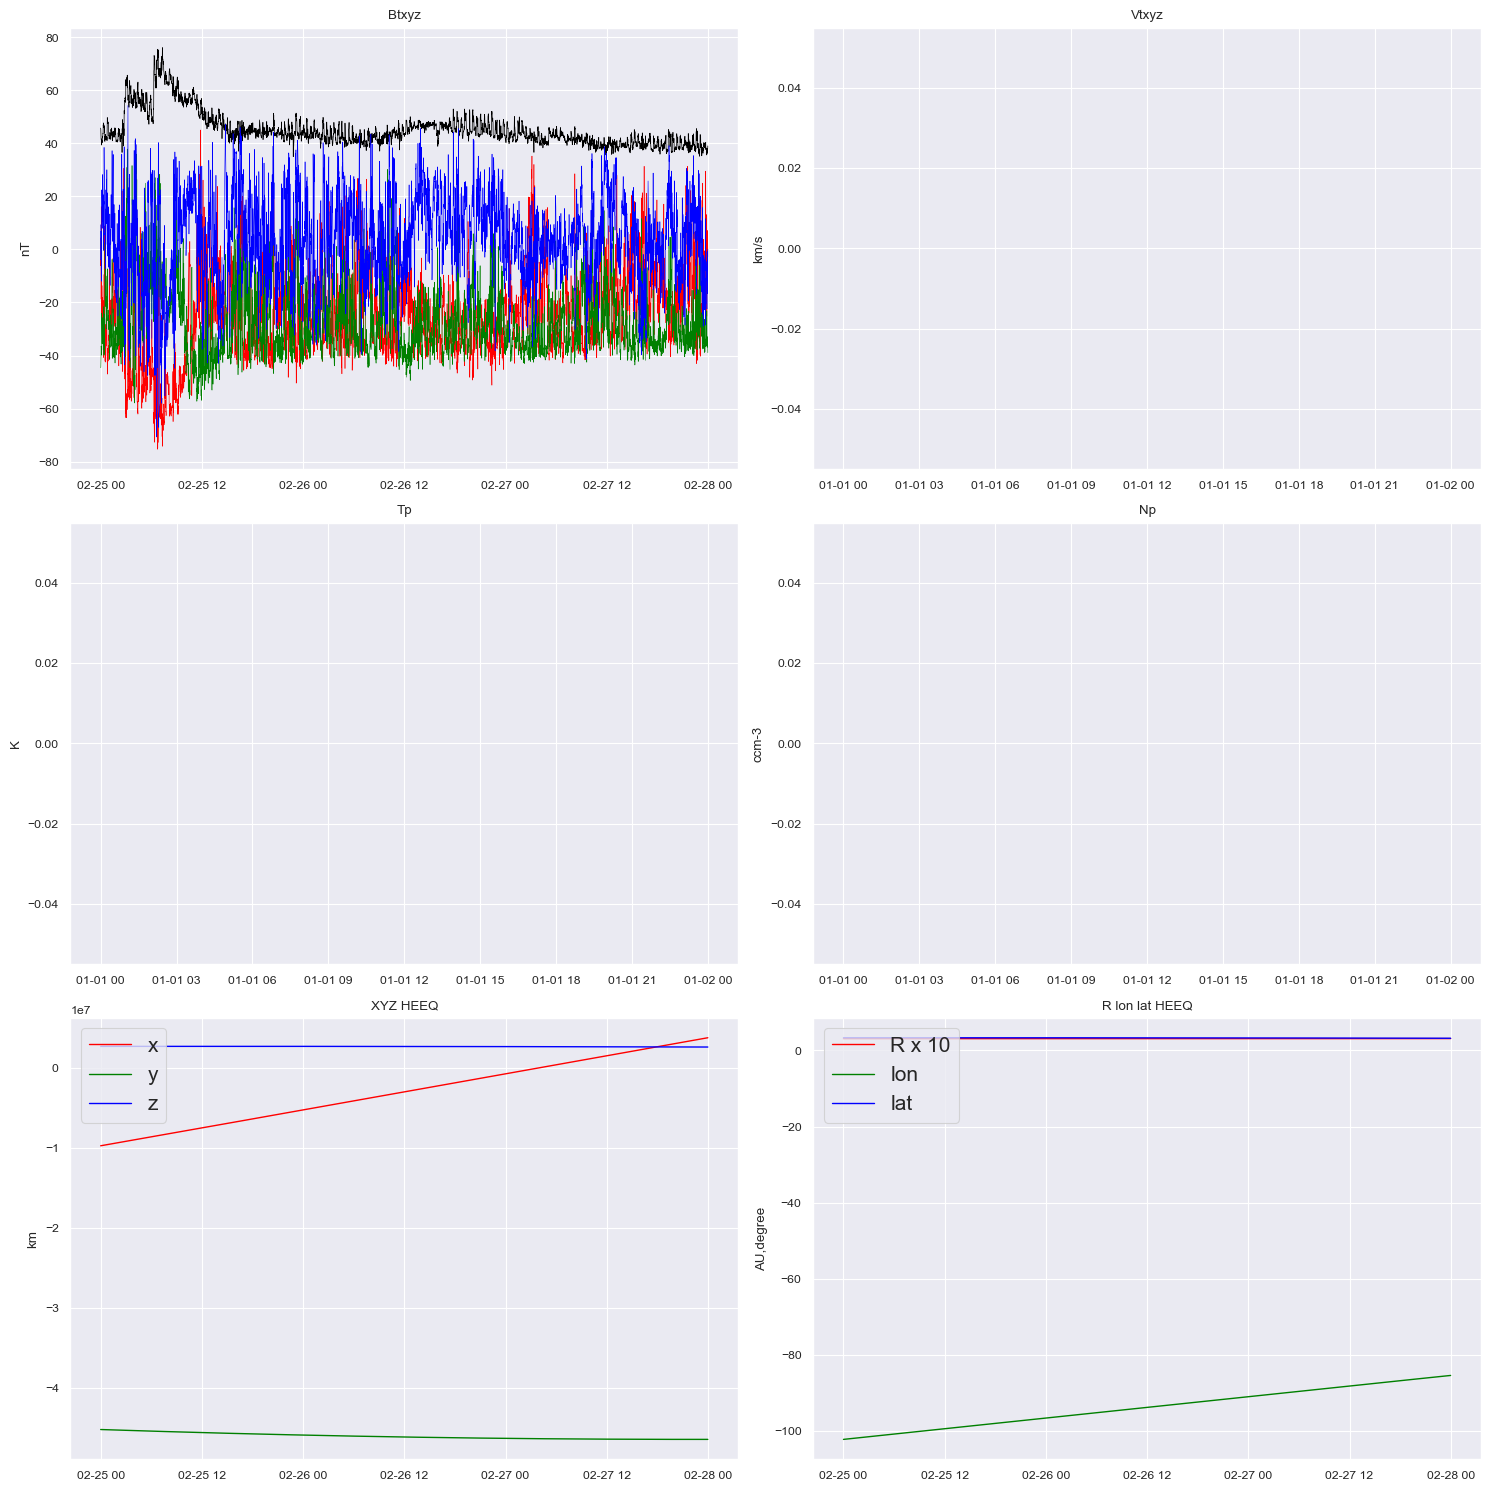

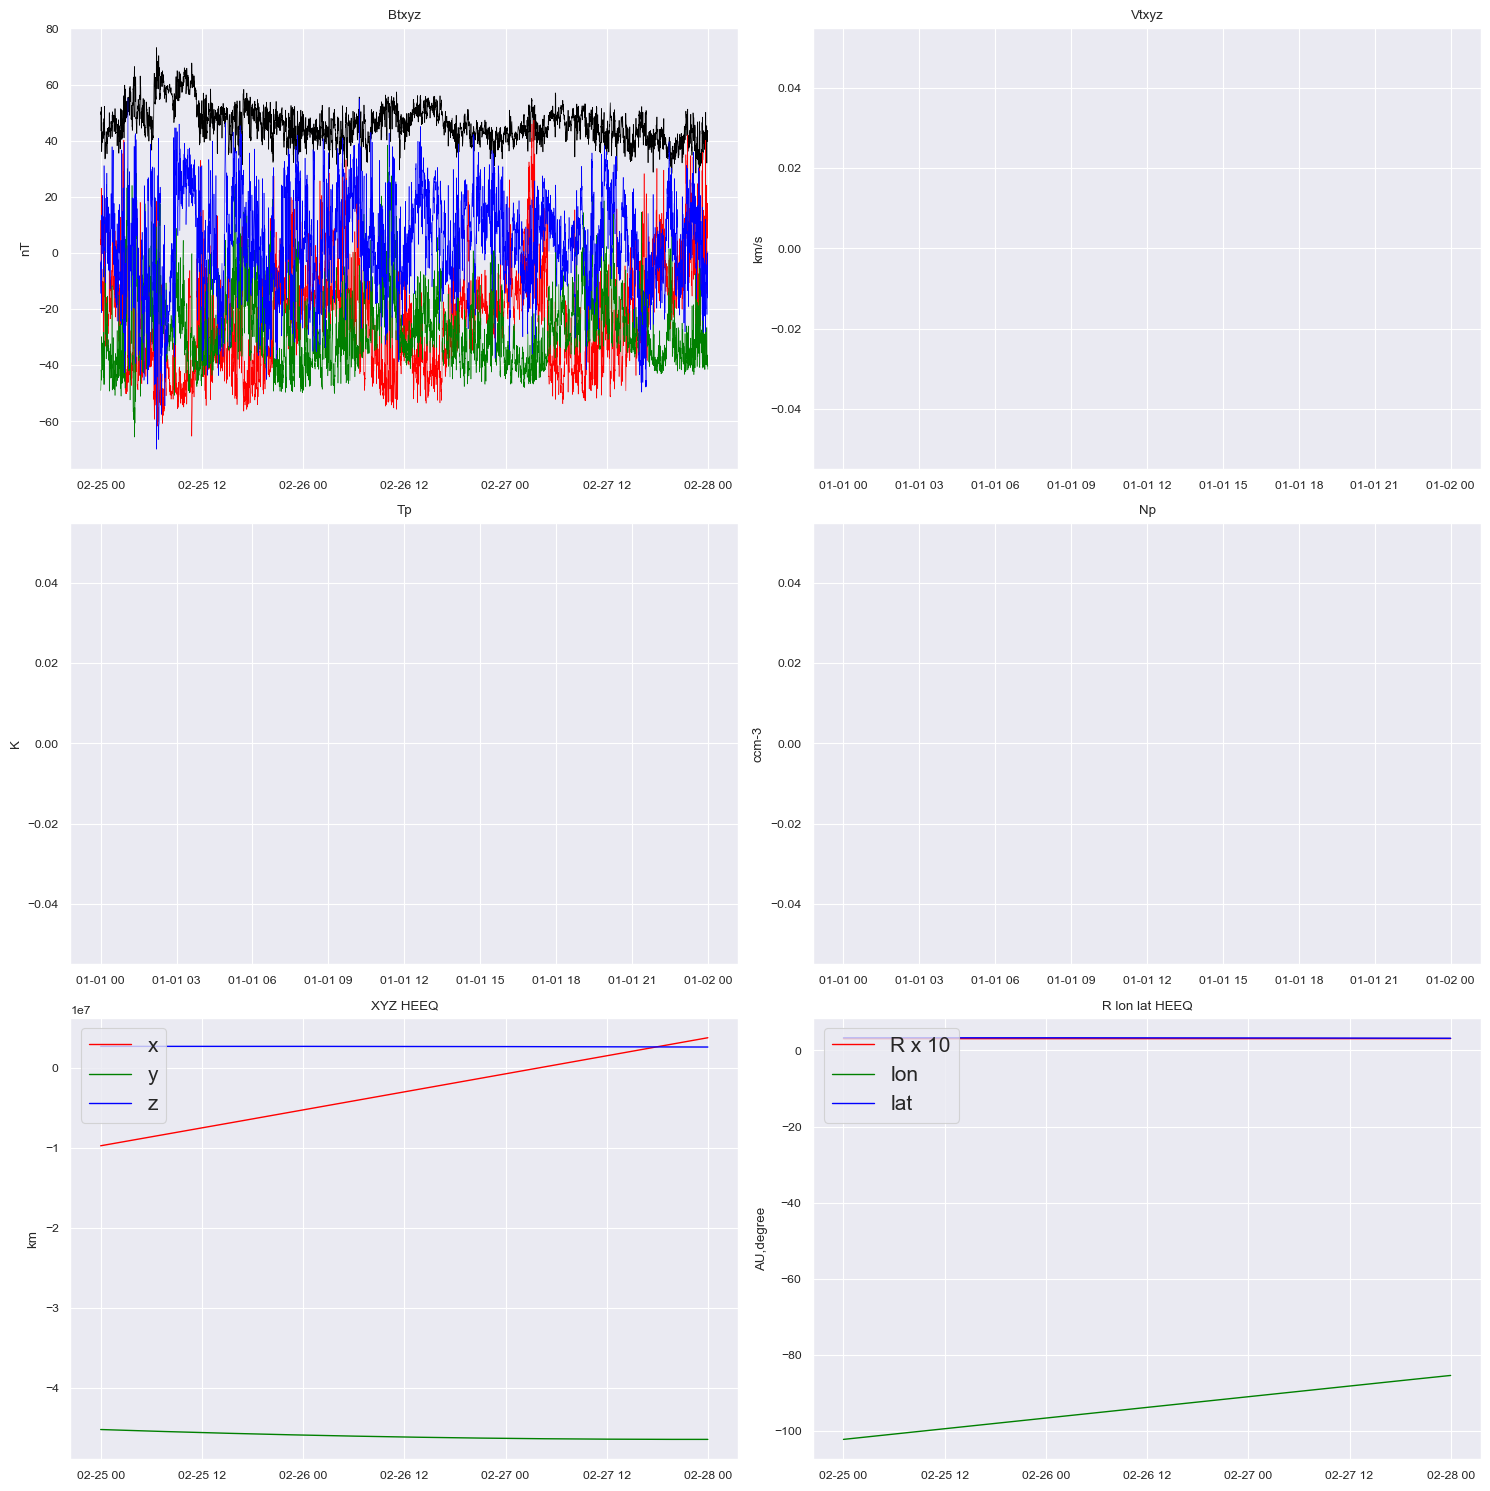

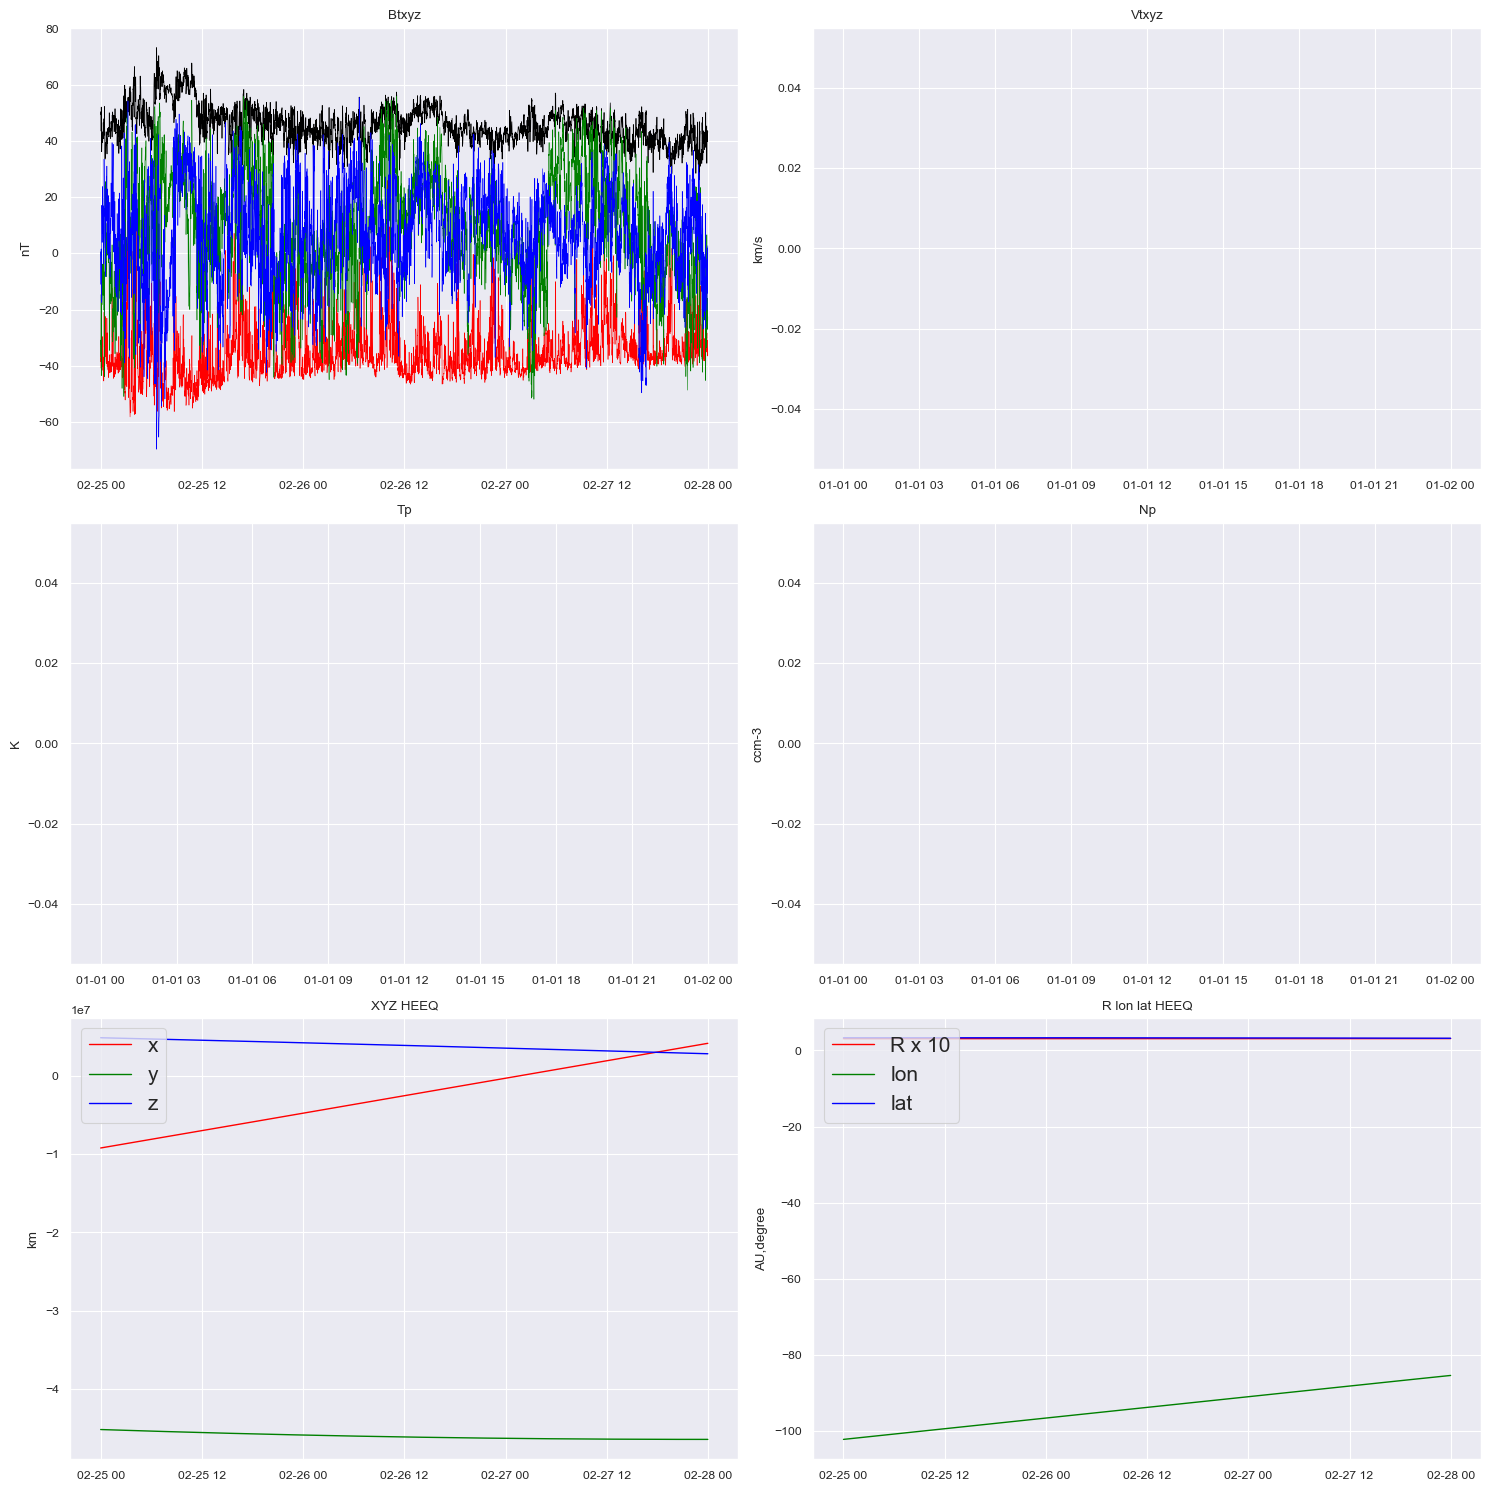

In [18]:
if get_bepi > 0:  
    
    ### outbound

    filebepi='bepi_ob_2019_now_e2k.p'

    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filebepi='bepi_ob_e2k_test.p'

    [data,hbepi_ob]=pickle.load(open(data_path+filebepi, "rb"))
    print(hbepi_ob)
    print(' ')
    hp.data_overview_plot(data,plot_path+'bepi/'+filebepi[:-2])
    
    
    
    ### inbound

    filebepi='bepi_ib_2019_now_e2k.p'

    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filebepi='bepi_ib_e2k_test.p'

    [data,hbepi_ib]=pickle.load(open(data_path+filebepi, "rb"))
    print(hbepi_ib)
    print(' ')
    hp.data_overview_plot(data,plot_path+'bepi/'+filebepi[:-2])
    
    #inbound rtn
    filebepi='bepi_ib_2019_now_rtn.p'

    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filebepi='bepi_ib_rtn_test.p'

    [data,hbepi_ib_rtn]=pickle.load(open(data_path+filebepi, "rb"))
    print(hbepi_ib_rtn)
    print(' ')
    hp.data_overview_plot(data,plot_path+'bepi/'+filebepi[:-2])
    
    
    
    

### STEREO-A science data

In [25]:

print(' ')

####### control parameter    

#for server
start_time= datetime(2007,1,1)
end_time = datetime.utcnow() 
sta_file=data_path+'stereoa_2007_now_rtn.p'


#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2023,11,1)
    end_time  = datetime(2023,12,1)
    sta_file=data_path+'stereoa_rtn_test.p'

    
if get_stereoa > 0:   

    t0 = time.time()  

    print(' ')
    print('------ STEREO-A science data  ------------------')

    print('download STEREO-A science data until today ')
    print(stereoa_path)

    hd.download_stereoa_merged(start_time,end_time,stereoa_path)    

    print('process STEREO-A to pickle')

    hd.create_stereoa_pkl(start_time,end_time,sta_file,stereoa_path,kernels_path)
    
    t1 = time.time()  

    print(' ')
    print('------ STEREO-A done in ', np.round((t1-t0)/60,2), 'minutes')  


else:
    print('STEREO-A data NOT downloaded and pickled, turn on switch')  



 
 
------ STEREO-A science data  ------------------
download STEREO-A science data until today 
/Users/chris/python/data/stereoa/
sta_l2_magplasma_1m_20230101_v05.cdf has already been downloaded.
process STEREO-A to pickle
/Users/chris/python/data/stereoa/impact/merged/level2/sta_l2_magplasma_1m_20230101_v04.cdf
/Users/chris/python/data/kernels/
 
------ STEREO-A done in  0.15 minutes


Science level 2 solar wind magnetic field and plasma data (IMPACT) from STEREO A, obtained from https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l2/impact/magplasma/1min/ Timerange: 2023-Nov-01 00:10 to 2023-Nov-30 23:49, with a time resolution of 1 min. The data are available in a numpy recarray, fields can be accessed by stereoa.time, stereoa.bx, stereoa.vt etc. Total number of data points: 38568. Units are btxyz [nT, RTN], vtxy  [km s^-1, RTN], np[cm^-3], tp [K], heliospheric position x/y/z [km], r/lon/lat [AU, degree, HEEQ]. Made with heliocats/data_update_web_science.ipynb by Emma Davies and Christian Möstl. File creation date: 2025-Mar-21 15:16 UTC


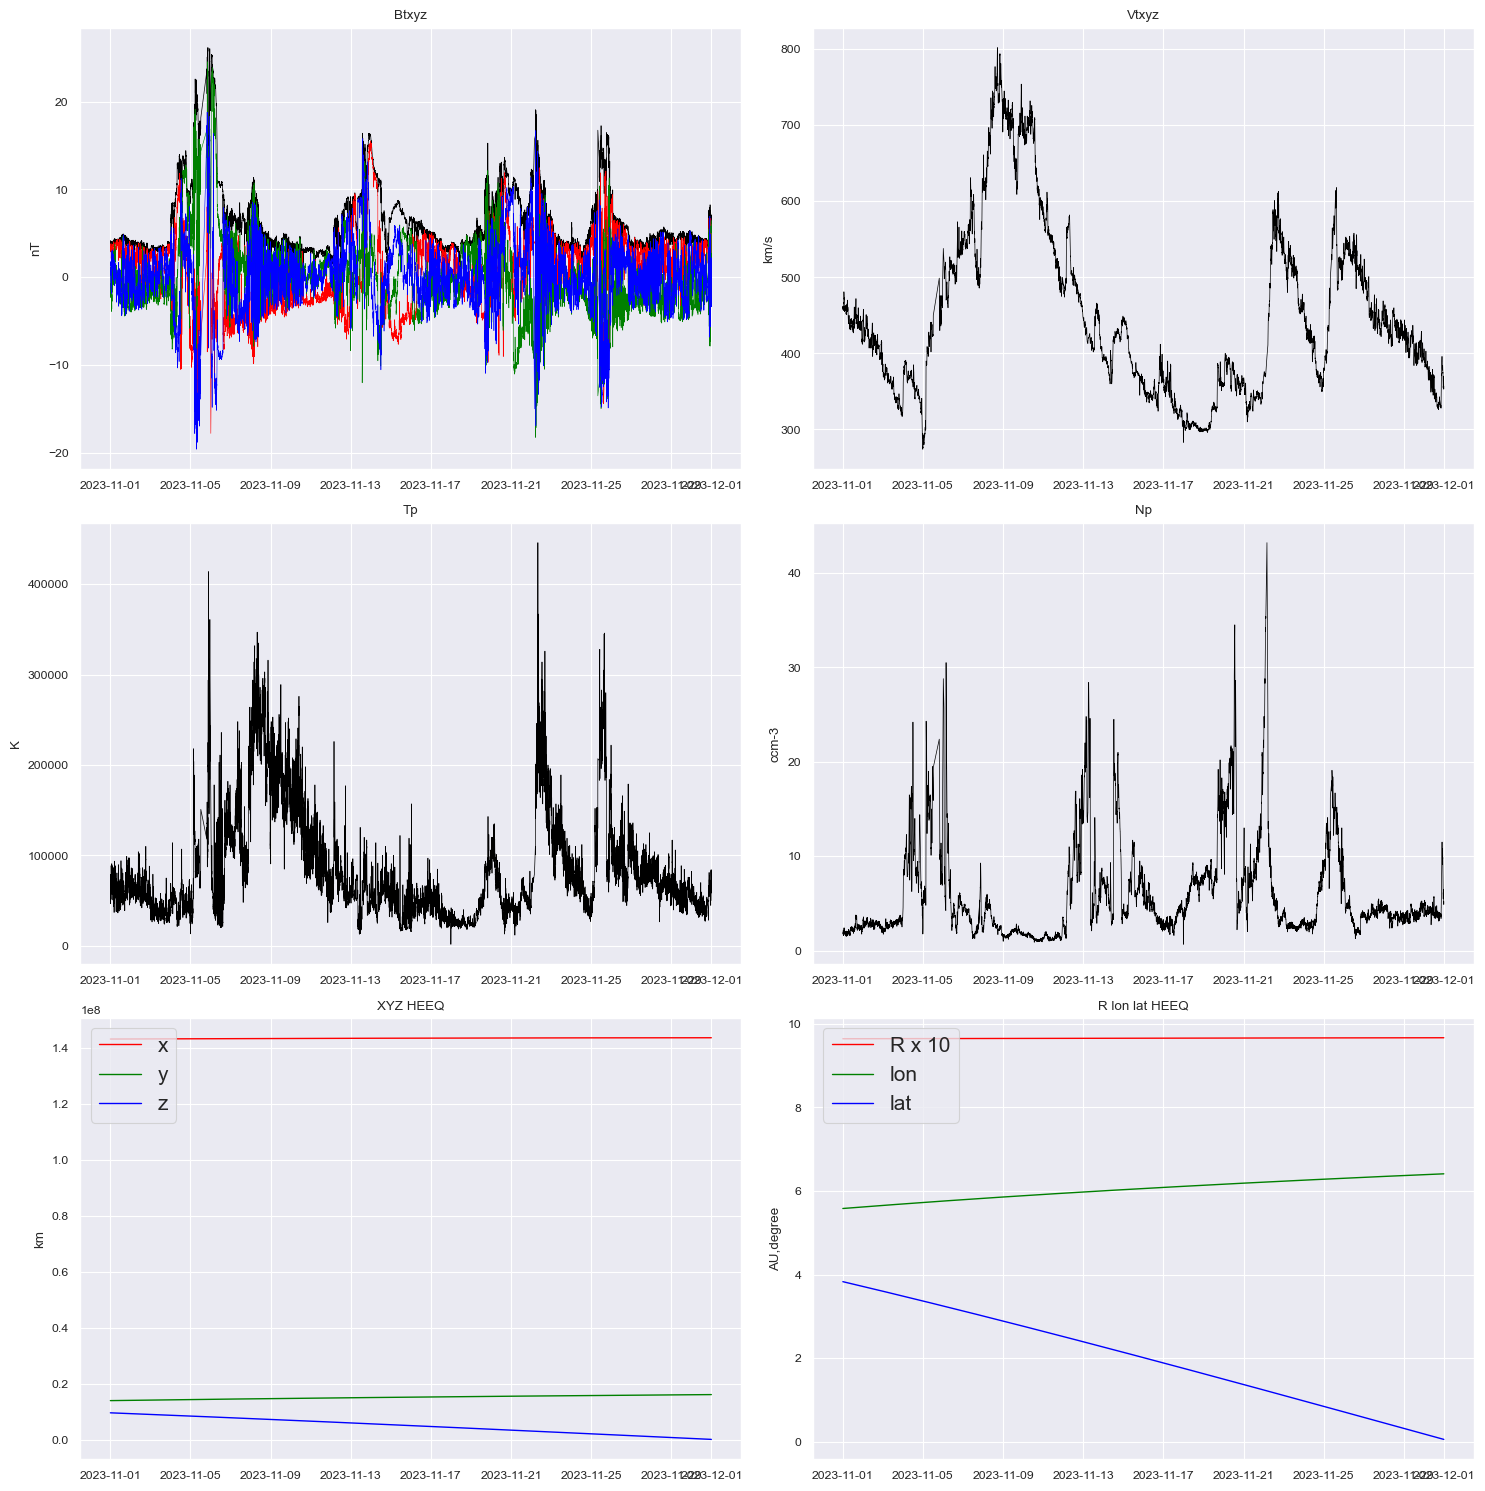

In [26]:
if get_stereoa > 0:  
    
    ### data checks

    #filesta='stereoa_2007_now_rtn.p'   
    filesta='stereoa_2007_now_rtn.p'   

    if debug_mode > 0: 
        importlib.reload(hd) 
        importlib.reload(hp) 
        filesta='stereoa_rtn_test.p'

    [data,hsta]=pickle.load(open(data_path+filesta, "rb"))
    ############ print header

    print(hsta)

    ########## add overview plots

    hp.data_overview_plot(data,plot_path+'stereoa/'+filesta[:-2])

#### write header file for science daily updates

In [14]:
text = open(data_path+'new_data_headers.txt', 'w')
text.write('Contains headers for the data files which are updated daily.'+'\n \n')
text.write('File creation date:  '+datetime.utcnow().strftime("%Y-%b-%d %H:%M") +' \n \n')


text.write('STEREO-A: '+sta_file+'\n \n'+ hsta+' \n \n')
#text.write('load with: >> [sta,hsta]=pickle.load(open("'+data_path+filesta+'", "rb"))') 
text.write(' \n \n \n \n')

text.write('Wind GSE: '+wind_file+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
text.write(' \n \n \n \n')

text.write('Wind HEEQ: '+wind_file_heeq+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
text.write(' \n \n \n \n')

text.write('Wind RTN: '+wind_file_rtn+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
text.write(' \n \n \n \n')


text.write('SolO: '+solo_file+'\n \n'+ hsolo+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
text.write(' \n \n \n \n')


text.write('PSP: '+psp_file+'\n \n'+ hpsp+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
text.write(' \n \n \n \n')


text.write('BepiColombo: '+bepi_file_ib+'\n \n'+ hbepi_ib+' \n \n')
#text.write('load with: >> [o,ho]=pickle.load(open("'+data_path+fileomni+'", "rb" ))') 
text.write(' \n \n \n \n')

text.write('BepiColombo: '+bepi_file_ob+'\n \n'+ hbepi_ob+' \n \n')
#text.write('load with: >> [o,ho]=pickle.load(open("'+data_path+fileomni+'", "rb" ))') 
text.write(' \n \n \n \n')

text.close()


t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full science data update:', np.round((t1all-t0all)/60,2), 'minutes')
print('--------------------------------------------------------------------------------------')

NameError: name 'hwin' is not defined